# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Фронт работы:**
1. Изучить и подготовить данные для обучения модели;
2. Обучить модель и проверить её качество;
3. Задать переменные для расчетов, написать функцию расчета прибыли;
4. Написать функцию для расчета средней прибыли, доверительного интервала и риска убытка;
5. Сделать вывод о проделанной работе и полученных результатах.

## Загрузка и подготовка данных

In [1]:
#Подгружаем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
#Запишем данные в переменные
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

#Изучим данные
display(df0.head())
display(df1.head())
display(df2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
#Изучим общую информацию о датафреймах
df0.info()
print('')
df1.info()
print('')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

Типы данных в порядке, пропусков нет.

In [4]:
#Проверяем наличие дубликатов
print(df0.duplicated().sum())
print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0
0


In [5]:
#Проверим дубликаты по id
print(df0['id'].duplicated().sum())
print(df1['id'].duplicated().sum())
print(df2['id'].duplicated().sum())

10
4
4


Дубликаты по id есть в каждом датафрейме, однако непонятно, какой из них удалить, а какой оставить, потому что данные в других столбцах не совпадают. Поэтому, удалять их не будем — их мало и они не смогут сильно повлиять на модель.

In [6]:
#Удаляем лишние столбцы (id)
df0 = df0.drop(columns='id')
df1 = df1.drop(columns='id')
df2 = df2.drop(columns='id')

#Проверяем
display(df0.head())
display(df1.head())
display(df2.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


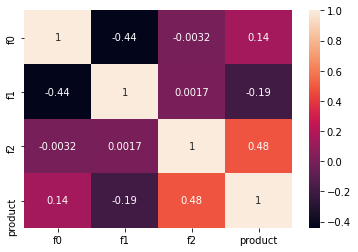

In [7]:
#Визуализируем корреляцию столбцов df0
sns.heatmap(df0.corr(), annot=True);

Наблюдается отрицательная корреляция между f1 и f0 и положительная между f2 и product.

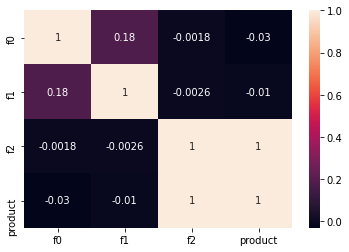

In [8]:
#Визуализируем корреляцию столбцов df1
sns.heatmap(df1.corr(), annot=True);

Крайне сильная положительная корреляция между f2 и product.

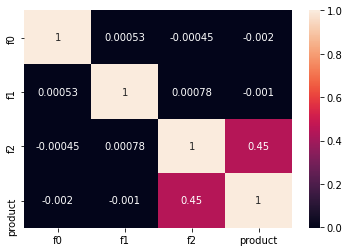

In [9]:
#Визуализируем корреляцию столбцов df2
sns.heatmap(df2.corr(), annot=True);

Положительная корреляция между f2 и product.

## Обучение и проверка модели

Поскольку у нас три датафрейма, чтобы избежать повторов, напишем функцию, принимающую на вход датафрейм и на выходе выдающую данные, которые требуются по заданию: предсказания и правильные ответы на валидационной выборке, а средний запас предсказанного сырья и RMSE модели.

In [10]:
#Функция делит df на фичи и таргет, масштабирует,
#обучает модель линейной регрессии и выдает искомые данные.
def split_learn(df):
    features = df.drop(columns='product')
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=12345
    )
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    
    rmse = mean_squared_error(target_valid, predictions)**0.5
    mean_product = predictions.mean()
        
    return predictions, target_valid.reset_index(drop=True), mean_product, rmse

In [11]:
#Нулевой регион
predictions0, target_valid0, mean_product0, rmse0 = split_learn(df0)
print(f'Средний запас сырья на скважину в нулевом регионе: {mean_product0.round(2)} тысяч баррелей')
print(f'RMSE: {rmse0.round(2)}')

Средний запас сырья на скважину в нулевом регионе: 92.59 тысяч баррелей
RMSE: 37.58


In [12]:
#Первый регион
predictions1, target_valid1, mean_product1, rmse1 = split_learn(df1)
print(f'Средний запас сырья на скважину в первом регионе: {mean_product1.round(2)} тысяч баррелей')
print(f'RMSE: {rmse1.round(2)}')

Средний запас сырья на скважину в первом регионе: 68.73 тысяч баррелей
RMSE: 0.89


In [13]:
#Второй регион
predictions2, target_valid2, mean_product2, rmse2 = split_learn(df2)
print(f'Средний запас сырья на скважину во втором регионе: {mean_product2.round(2)} тысяч баррелей')
print(f'RMSE: {rmse2.round(2)}')

Средний запас сырья на скважину во втором регионе: 94.97 тысяч баррелей
RMSE: 40.03


1. Минимальная RMSE модели (0.89) у первого региона. Это было очевидно изначально, учитывая корреляцию `df2` и `product` в единицу. Тем не менее, средний запас сырья на скважину в регионе оставляет желать лучшего — всего 68.73 тысяч баррелей, что является наименьшийм показателем среди регионов).

2. Лидер по количеству сырья и, одновременно, по величине RMSE модели — второй регион с запасами почти в 95 тысяч баррелей и RMSE модели в 40.03.

3. Нулевой регион может похвастаться хорошим запасом сырья в 92.59 тысяч баррелей. Тем не мнее, RMSE модели составляет 37.58.

## Подготовка к расчёту прибыли

In [14]:
#Зададим значения переменным для расчетов
budget = 10000000000
price = 450000
loss_prob = 0.025
wells = 500
best_wells = 200

In [15]:
#Считаем достаточный объем скважины

print('Достаточный объём сырья для безубыточной разработки новой скважины:',
      round(budget / price / best_wells, 2), 'тысяч баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тысяч баррелей


Вспомним показатели средних запасов на скважину по регионам:
1. Нулевой = 92.59 тысяч баррелей;
2. Первый = 68.73 тысяч баррелей;
3. Второй = 94.97 тысяч баррелей.

Мы видим, что достаточный объем сырья для безубыточной разработки (111.11) существенно больше среднего показателя запасов сырья по каждому из регионов, особенно, в случае с первым регионом.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [16]:
#Пишем функцию
def profit(predictions, target):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_sorted = target[predictions_sorted.index][:best_wells]
    return target_sorted.sum() * price - budget

## Расчёт прибыли и рисков 

Напишем функцию *bootstrap*, выдающую нам данные о средней прибыльности региона, доверительном интервале и риске убытка.

In [17]:
#Пишем функцию bootstrap
def bootstrap(predictions, target):
    state = np.random.RandomState(12345)
    values = []

    for i in range(1000):
        target_sample = target.sample(n=wells, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        values.append(profit(predictions_sample, target_sample))
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean_profit = values.mean()
    risk = (values < 0).mean()
    print(f'Средняя прибыль региона: {round(mean_profit, 2)}')
    print(f'Доверительный интервал: от {round(lower, 2)} до {round(upper, 2)}')
    print(f'Риск убытка: {risk:.2%}')

In [18]:
print('Данные по нулевому региону')
bootstrap(predictions0, target_valid0)

Данные по нулевому региону
Средняя прибыль региона: 425938526.91
Доверительный интервал: от -102090094.84 до 947976353.36
Риск убытка: 6.00%


In [19]:
print('Данные по первому региону')
bootstrap(predictions1, target_valid1)

Данные по первому региону
Средняя прибыль региона: 515222773.44
Доверительный интервал: от 68873225.37 до 931547591.26
Риск убытка: 1.00%


In [20]:
print('Данные по второму региону')
bootstrap(predictions2, target_valid2)

Данные по второму региону
Средняя прибыль региона: 435008362.78
Доверительный интервал: от -128880547.33 до 969706954.18
Риск убытка: 6.40%


### Вывод:

- Несмотря на внушительные средние запасы сырья на скважину в нулевом (92.59) и втором регионах (94.97), их RMSE 37.58 и 40.03 соответственно, что говорит о не лучшем качестве модели.
- В первом регионе средние запасы сырья на скважину скромнее — 68.73 тысячи баррелей, однако качество модели превосходное — RMSE = 0.89.
- После подсчетов средней прибыли регионов, доверительных интервалов и рисков убытка, можно сделать вывод, что нулевой и второй регионы не проходят по условию задачи, в котором говорится о максимально допустимом риске вероятности убытка в 2.5%.

Можем сделать вывод, что лидером, на которого будем делать ставку, стал первый регион (df1) со следующими показателями:
1. Средняя прибыль региона — 515.22 млн рублей;
2. Доверительный интервал — от 68.87 до 931.55 млн рублей;
3. Риск убытка — 1%.